In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Flatten, Input, Conv2D, MaxPooling2D, Concatenate, Reshape
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../data/cleaned_data.csv', parse_dates=['date'])
df.head()

,date,store_nbr,family,sales,onpromotion,holiday_type,locale,transferred,dcoilwtico,city,state,store_type,cluster,transactions,year,month,week,quarter,day_of_week,is_crisis,sales_lag_7,rolling_mean_7,is_weekend,is_holiday,promo_last_7_days,days_to_holiday,promotion_status
0,2013-01-01,1,AUTOMOTIVE,0.00,0,Holiday,National,False,93.14,Quito,Pichincha,D,13,0.00,2013,1,1,1,Tuesday,0,0.00,0.00,0,1,0.00,0,Not On Promotion
1,2013-01-01,1,BABY CARE,0.00,0,Holiday,National,False,93.14,Quito,Pichincha,D,13,0.00,2013,1,1,1,Tuesday,0,0.00,0.00,0,1,0.00,0,Not On Promotion
2,2013-01-01,1,BEAUTY,0.00,0,Holiday,National,False,93.14,Quito,Pichincha,D,13,0.00,2013,1,1,1,Tuesday,0,0.00,0.00,0,1,0.00,0,Not On Promotion
3,2013-01-01,1,BEVERAGES,0.00,0,Holiday,National,False,93.14,Quito,Pichincha,D,13,0.00,2013,1,1,1,Tuesday,0,0.00,0.00,0,1,0.00,0,Not On Promotion
4,2013-01-01,1,BOOKS,0.00,0,Holiday,National,False,93.14,Quito,Pichincha,D,13,0.00,2013,1,1,1,Tuesday,0,0.00,0.00,0,1,0.00,0,Not On Promotion


In [3]:
df[(df['date'].dt.year == 2017)].tail(10)

,date,store_nbr,family,sales,onpromotion,holiday_type,locale,transferred,dcoilwtico,city,state,store_type,cluster,transactions,year,month,week,quarter,day_of_week,is_crisis,sales_lag_7,rolling_mean_7,is_weekend,is_holiday,promo_last_7_days,days_to_holiday,promotion_status
3000878,2017-08-15,54,MAGAZINES,2.00,0,Holiday,Local,False,49.07,El Carmen,Manabi,C,3,802.00,2017,8,33,3,Tuesday,0,0.00,26.43,0,1,6.00,1687,Not On Promotion
3000879,2017-08-15,54,MEATS,57.84,0,Holiday,Local,False,49.07,El Carmen,Manabi,C,3,802.00,2017,8,33,3,Tuesday,0,37.00,35.60,0,1,6.00,1687,Not On Promotion
3000880,2017-08-15,54,PERSONAL CARE,169.00,5,Holiday,Local,False,49.07,El Carmen,Manabi,C,3,802.00,2017,8,33,3,Tuesday,0,158.00,39.17,0,1,7.00,1687,On Promotion
3000881,2017-08-15,54,PET SUPPLIES,0.00,0,Holiday,Local,False,49.07,El Carmen,Manabi,C,3,802.00,2017,8,33,3,Tuesday,0,0.00,39.17,0,1,7.00,1687,Not On Promotion
3000882,2017-08-15,54,PLAYERS AND ELECTRONICS,2.00,0,Holiday,Local,False,49.07,El Carmen,Manabi,C,3,802.00,2017,8,33,3,Tuesday,0,3.00,39.32,0,1,7.00,1687,Not On Promotion
3000883,2017-08-15,54,POULTRY,59.62,0,Holiday,Local,False,49.07,El Carmen,Manabi,C,3,802.00,2017,8,33,3,Tuesday,0,73.29,47.05,0,1,7.00,1687,Not On Promotion
3000884,2017-08-15,54,PREPARED FOODS,94.00,0,Holiday,Local,False,49.07,El Carmen,Manabi,C,3,802.00,2017,8,33,3,Tuesday,0,86.00,67.05,0,1,6.00,1687,Not On Promotion
3000885,2017-08-15,54,PRODUCE,915.37,76,Holiday,Local,False,49.07,El Carmen,Manabi,C,3,802.00,2017,8,33,3,Tuesday,0,790.01,150.57,0,1,9.00,1687,On Promotion
3000886,2017-08-15,54,SCHOOL AND OFFICE SUPPLIES,0.00,0,Holiday,Local,False,49.07,El Carmen,Manabi,C,3,802.00,2017,8,33,3,Tuesday,0,0.00,141.40,0,1,9.00,1687,Not On Promotion
3000887,2017-08-15,54,SEAFOOD,3.00,0,Holiday,Local,False,49.07,El Carmen,Manabi,C,3,802.00,2017,8,33,3,Tuesday,0,12.00,112.82,0,1,3.00,1687,Not On Promotion


In [4]:
df.isna().sum()

date                       0
store_nbr                  0
family                     0
sales                      0
onpromotion                0
holiday_type               0
locale               2551824
transferred                0
dcoilwtico                 0
city                       0
state                      0
store_type                 0
cluster                    0
transactions               0
year                       0
month                      0
week                       0
quarter                    0
day_of_week                0
is_crisis                  0
sales_lag_7                0
rolling_mean_7             0
is_weekend                 0
is_holiday                 0
promo_last_7_days          0
days_to_holiday            0
promotion_status           0
dtype: int64

In [5]:
df['locale'].fillna('None', inplace=True)

In [6]:
feature_cols = [
    'store_nbr', 'family',
    'onpromotion', 'transactions', 'dcoilwtico',
    'sales_lag_7', 'rolling_mean_7', 'holiday_type', 
    'is_holiday', 'is_weekend', 'promo_last_7_days',
    'days_to_holiday', 'year', 'month', 'week', 'day_of_week'
]

target_col = 'sales'

In [7]:
day_of_week_mapping = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
    'Friday': 4, 'Saturday': 5, 'Sunday': 6
}
df['day_of_week'] = df['day_of_week'].map(day_of_week_mapping)

In [8]:
label_encoder = LabelEncoder()

cat_cols = ['family', 'holiday_type', 'locale', 'city', 'state', 'store_type', 'promotion_status']

for col in cat_cols:
    df[col] = label_encoder.fit_transform(df[col])

In [9]:
scaler = RobustScaler()
numerical_cols = ['onpromotion', 'transactions', 'dcoilwtico', 'sales_lag_7', 'rolling_mean_7', 
                  'is_holiday', 'is_weekend', 'promo_last_7_days', 'days_to_holiday', 
                  'year', 'month', 'week']

df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [10]:
date_counts = df['date'].value_counts().sort_index()

# Filter dates that do not have 1782 rows
dates_not_1782 = date_counts[date_counts != 1782]

print("Dates that do not have 1782 rows:")
print(dates_not_1782)

Dates that do not have 1782 rows:
Series([], Name: count, dtype: int64)


# The Discovery of duplicates 
Look at the `preprocessing.py` as it will be added there

In [11]:
testing = df.sort_values(by=['date', 'store_nbr', 'family']).drop_duplicates(subset=['date', 'store_nbr', 'family'], keep='first')
testing['date'].value_counts().sort_index()[testing['date'].value_counts().sort_index() != 1782].index.tolist()
print(testing.holiday_type.value_counts().sort_index())
print(testing.shape)

holiday_type
0      64152
1       5346
2      87318
3     270864
4    2551824
5      14256
6       7128
Name: count, dtype: int64
(3000888, 27)


In [12]:
df.sort_values(by=['date', 'store_nbr', 'family'], inplace=True)

In [13]:
df_train = df[df['date'] < '2017-01-01']
df_test = df[df['date'] >= '2017-01-01']

In [14]:
X_train = df_train[feature_cols].to_numpy()
y_train = df_train[target_col].to_numpy()

X_test = df_test[feature_cols].to_numpy()
y_test = df_test[target_col].to_numpy()

X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

> The `.to_numpy` is to **convert** the X and y to **numpy arrays**, as it's best to pass it to a **deep learning model**

In [15]:
n_days = df['date'].nunique()
n_rows_per_day = 1782

days_in_2017 = df[df['date'].dt.year == 2017]['date'].nunique()
days_before_2017 = df[df['date'].dt.year < 2017]['date'].nunique()

X_test = X_test.reshape(days_in_2017, n_rows_per_day, X_test.shape[2])
X_train = X_train.reshape(days_before_2017 , n_rows_per_day, X_train.shape[2])

In [16]:
train_size = int(len(X_train) * 0.9)  
val_size = len(X_train) - train_size  

X_train, X_val = X_train[:train_size], X_train[train_size:]
y_train, y_val = y_train[:train_size], y_train[train_size:]

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,   
    restore_best_weights=True
)

In [18]:
vocab_sizes = {col: df[col].nunique() for col in cat_cols}

embedding_dim = 10

inputs = []
embeddings = []

# Time series input (using 30-day window)
time_series_input = Input(shape=(30, 1782, 16), name="time_series_input")

# Apply Conv2D and MaxPooling2D as you were doing
conv_layer = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(time_series_input)
max_pool_layer = MaxPooling2D(pool_size=(2, 2))(conv_layer)

# Reshape the output of the MaxPooling2D layer to 3D (batch_size, time_steps, features)
reshaped_layer = Reshape((-1, max_pool_layer.shape[1] * max_pool_layer.shape[2] * max_pool_layer.shape[3]))(max_pool_layer)

# Now pass the reshaped data to the LSTM
lstm_layer = LSTM(64, return_sequences=False)(reshaped_layer)

# Categorical Inputs
inputs = []
embeddings = []
for col in cat_cols:
    vocab_size = vocab_sizes[col]
    input_layer = Input(shape=(1,), name=f"{col}_input")
    embedding_layer = Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, name=f"{col}_embedding")(input_layer)
    embedding_flat = Flatten()(embedding_layer)

    inputs.append(input_layer)
    embeddings.append(embedding_flat)

# Merge all inputs
merged = Concatenate()(embeddings + [lstm_layer])
dense_layer = Dense(128, activation='relu')(merged)
dense_layer = Dropout(0.2)(dense_layer)

output = Dense(1, activation='linear')(dense_layer)

# Model definition
model = Model(inputs=inputs + [time_series_input], outputs=output)

In [19]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 time_series_input (InputLa  [(None, 30, 1782, 16)]       0         []                            
 yer)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 28, 1780, 64)         9280      ['time_series_input[0][0]']   
                                                                                                  
 family_input (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 holiday_type_input (InputL  [(None, 1)]                  0         []                       

In [20]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Num GPUs Available: {len(gpus)}")
else:
    print("No GPUs detected.")


TensorFlow version: 2.15.0
No GPUs detected.


In [26]:
X_train_cat_features = [df[col].values for col in cat_cols]
X_val_cat_features = [X_val[col].values for col in cat_cols]

history = model.fit(
    [X_train] + X_train_cat_features,  # Concatenate X_train with categorical columns
    y_train,  
    epochs=20, 
    batch_size=64,  
    validation_data=([X_val] + X_val_cat_features, y_val),  # Validation data
    callbacks=[early_stop]
)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [23]:
print(type(X_val))

<class 'numpy.ndarray'>


In [ ]:
print(X_val.shape)

(2332, 1782, 1)


In [ ]:
y_pred_scaled = model.predict(X_test)

# Inverse scale predictions and ground truth
y_true = y_test.reshape(-1, 1)
y_pred = y_pred_scaled.reshape(-1, 1)


19090/19090 [==============================] - 31s 2ms/step


In [ ]:
# Rebuild dummy scaler to invert only sales
dummy_df = pd.DataFrame(np.zeros((len(y_true), len(feature_cols) + 1)), columns=feature_cols + [target_col])
dummy_df[target_col] = y_true.ravel()
y_true_inv = scaler.inverse_transform(dummy_df)[:, -1]

dummy_df[target_col] = y_pred.ravel()
y_pred_inv = scaler.inverse_transform(dummy_df)[:, -1]

In [ ]:
mse = mean_squared_error(y_true_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_inv, y_pred_inv)

print(f'LSTM Model Evaluation \nMSE: {mse:.2f} \nRMSE: {rmse:.2f} \nR2: {r2:.2f}')

LSTM Model Evaluation 
MSE: 266525.96 
RMSE: 516.26 
R2: 0.86


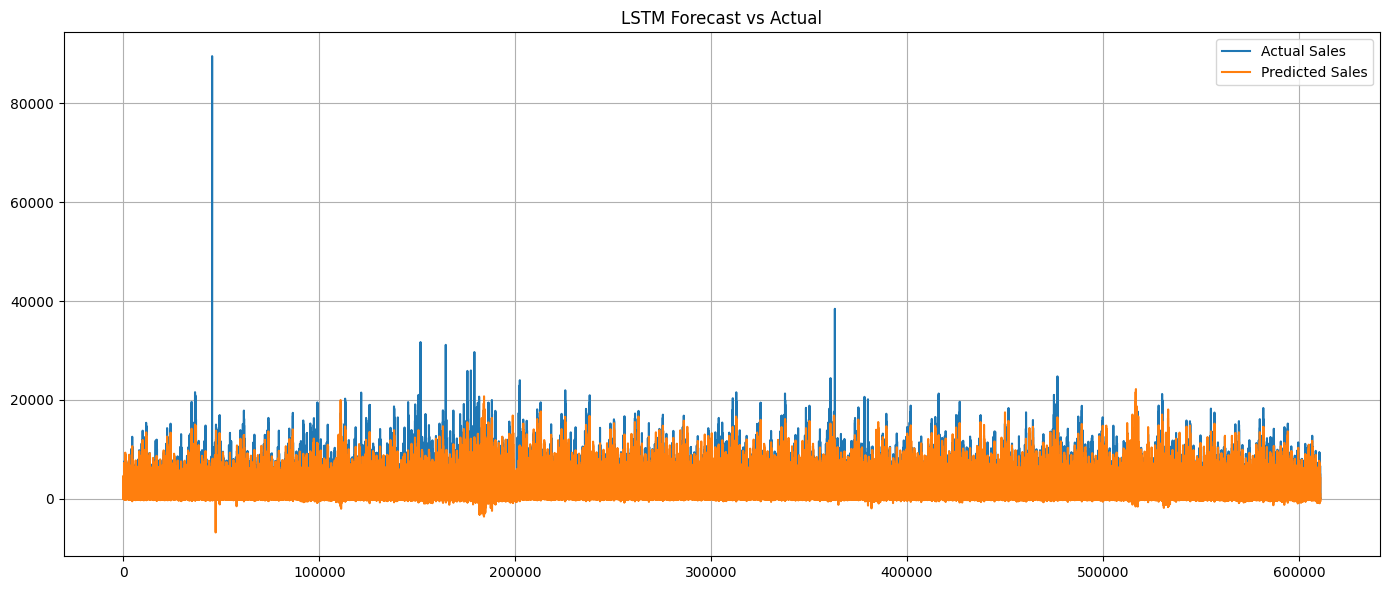

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(y_true_inv, label='Actual Sales')
plt.plot(y_pred_inv, label='Predicted Sales')
plt.title('LSTM Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()